### Import Necessary Module and Set Path 

In [177]:
import sqlite3 as lite
import os
from IPython.display import Image
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [178]:
import analysis as an

## Run Cyclus Input file

In [181]:
! rm 1year.sqlite
! cyclus year.xml -o 1year.sqlite --warn-limit 0 

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [183]:
# plotting function
import matplotlib.pyplot as plt
def stacked_bar(dictionary, timestep, xlabel, ylabel,
                title, outputname, init_year, width):
    prev =np.zeros(1)
    top_index = True
    plot_list = []
    for key in dictionary:
        label = str(key)
        if sum(dictionary[key]) == 0:
            print(label + ' has no values')
        elif top_index is True:
            plot = plt.bar(x=init_year + timestep,
                           height=dictionary[key],
                           width=width,
                           edgecolor='none',
                           label=label)
            prev = dictionary[key]
            top_index = False
            plot_list.append(plot)
        else:
            plot = plt.bar(x=init_year + timestep,
                           height=dictionary[key],
                           width=width,
                           edgecolor='none',
                           bottom=prev,
                           label=label)
            prev =np.add(prev, dictionary[key])
            plot_list.append(plot)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    axes = plt.gca()
    axes.autoscale(tight=True)
    plt.grid(True)
    plt.legend()
    plt.savefig(outputname + '.png', format='png',
                bbox_inches='tight')
    plt.close()

### The output file should be named 
         
          cyclus.sqlite

In [184]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('1year.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [185]:
# get number of reactors and capacity timeseries
power_dict = an.get_power_dict(cur)
stacked_bar(power_dict, timestep, 'Year', 'Deployed Capacity [GWe]',
            'Deployed reactor capacityies at the end of each year.',
            'power_plot', init_year, 1)
! mv power_plot.png ./results/power_plot.png

fac has no values


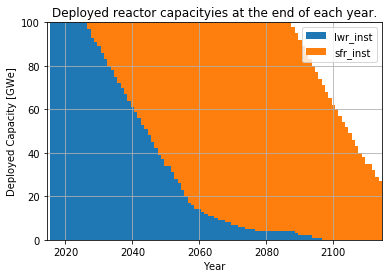

In [186]:
Image('./results/power_plot.png')

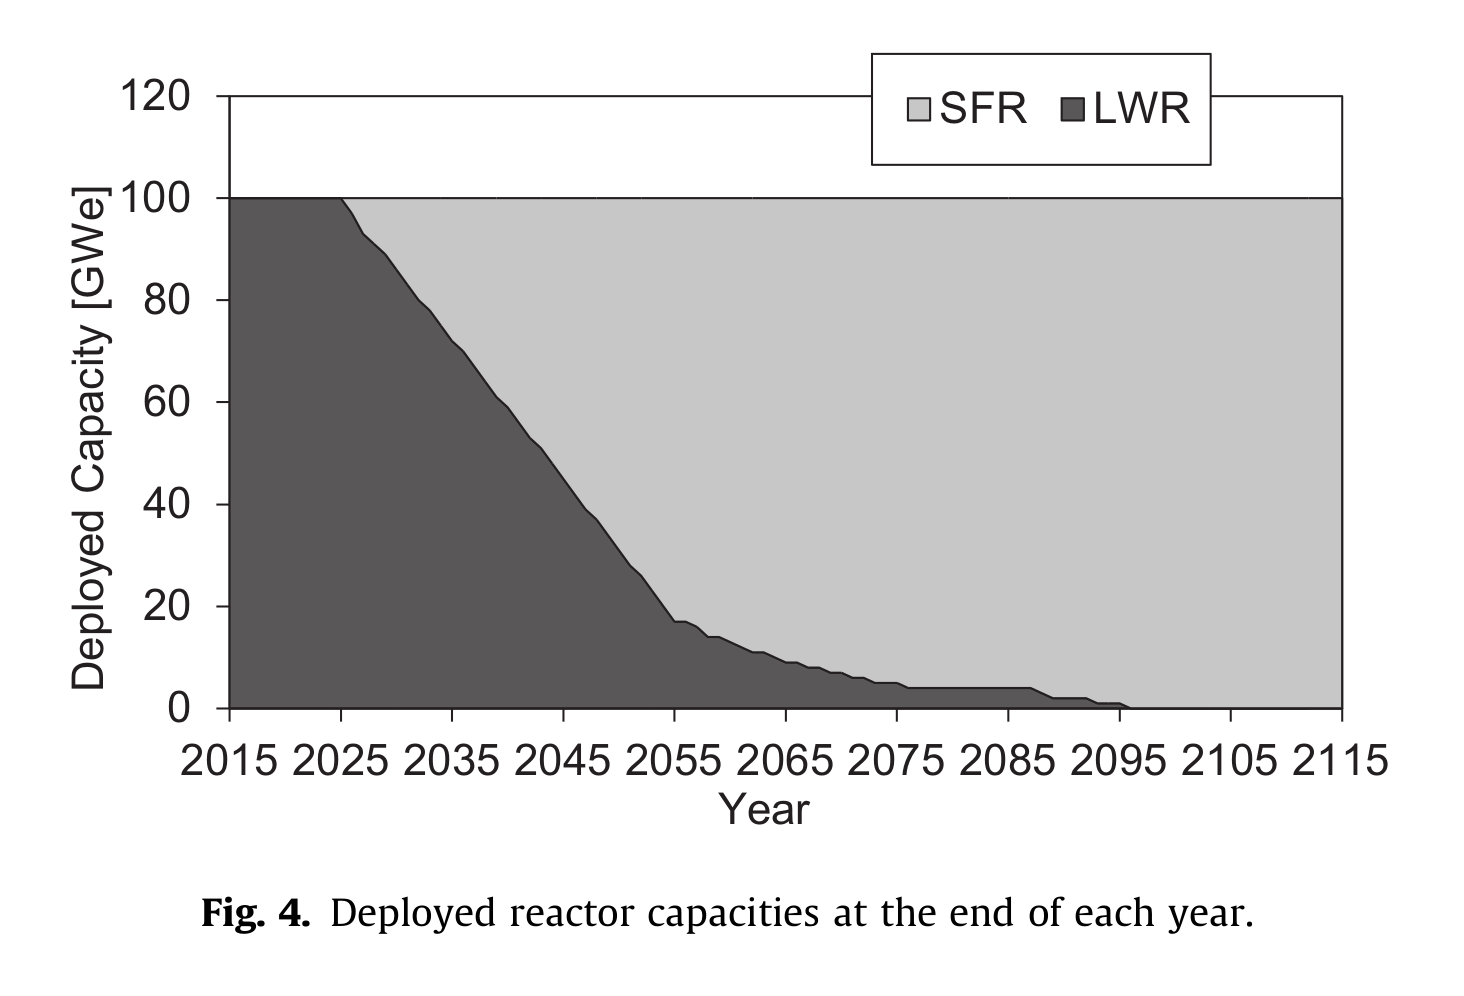

In [187]:
Image('./literature/power_plot.png')

In [188]:
# get deployment scheme
dep_dict = {}

# lwr decommission
lwr_dec = cur.execute('SELECT exittime FROM agentexit '
                      'INNER JOIN agententry ON '
                      'agentexit.agentid = agententry.agentid '
                      'WHERE prototype = "lwr"').fetchall()
dec_array = np.zeros(duration)
exittime_list = []
for row in lwr_dec:
    exittime_list.append(row['exittime'])
for i in range(1,duration):
    dec_array[i-1] = exittime_list.count(i)

dep_dict['LWRs retired'] = dec_array

# sfr deployment
sfr_dep = cur.execute('SELECT entertime FROM agententry '
                      'where prototype = "sfr"').fetchall()
dep_array = np.zeros(duration)
entertime_list = []
for row in sfr_dep:
    entertime_list.append(row['entertime'])
for i in range(1, duration):
    dep_array[i-1] = entertime_list.count(i)

dep_dict['SFRs started up'] = dep_array


plt.bar(init_year + timestep, dep_dict['LWRs retired'],
        label='LWRs retired')
plt.bar(init_year + timestep, dep_dict['SFRs started up'],
        label='SFRs started up', alpha=0.4)
plt.ylabel('Reactors')
plt.xlabel('Year')
plt.title('LWRs retired and SFRs started up each year')
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.legend()
plt.yticks(np.arange(0,15, 2))
plt.savefig('./results/dep.png', format='png',
            bbox_inches='tight')
plt.close()

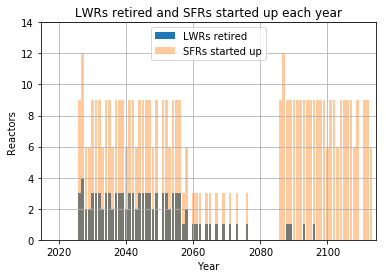

In [189]:
Image("./results/dep.png")

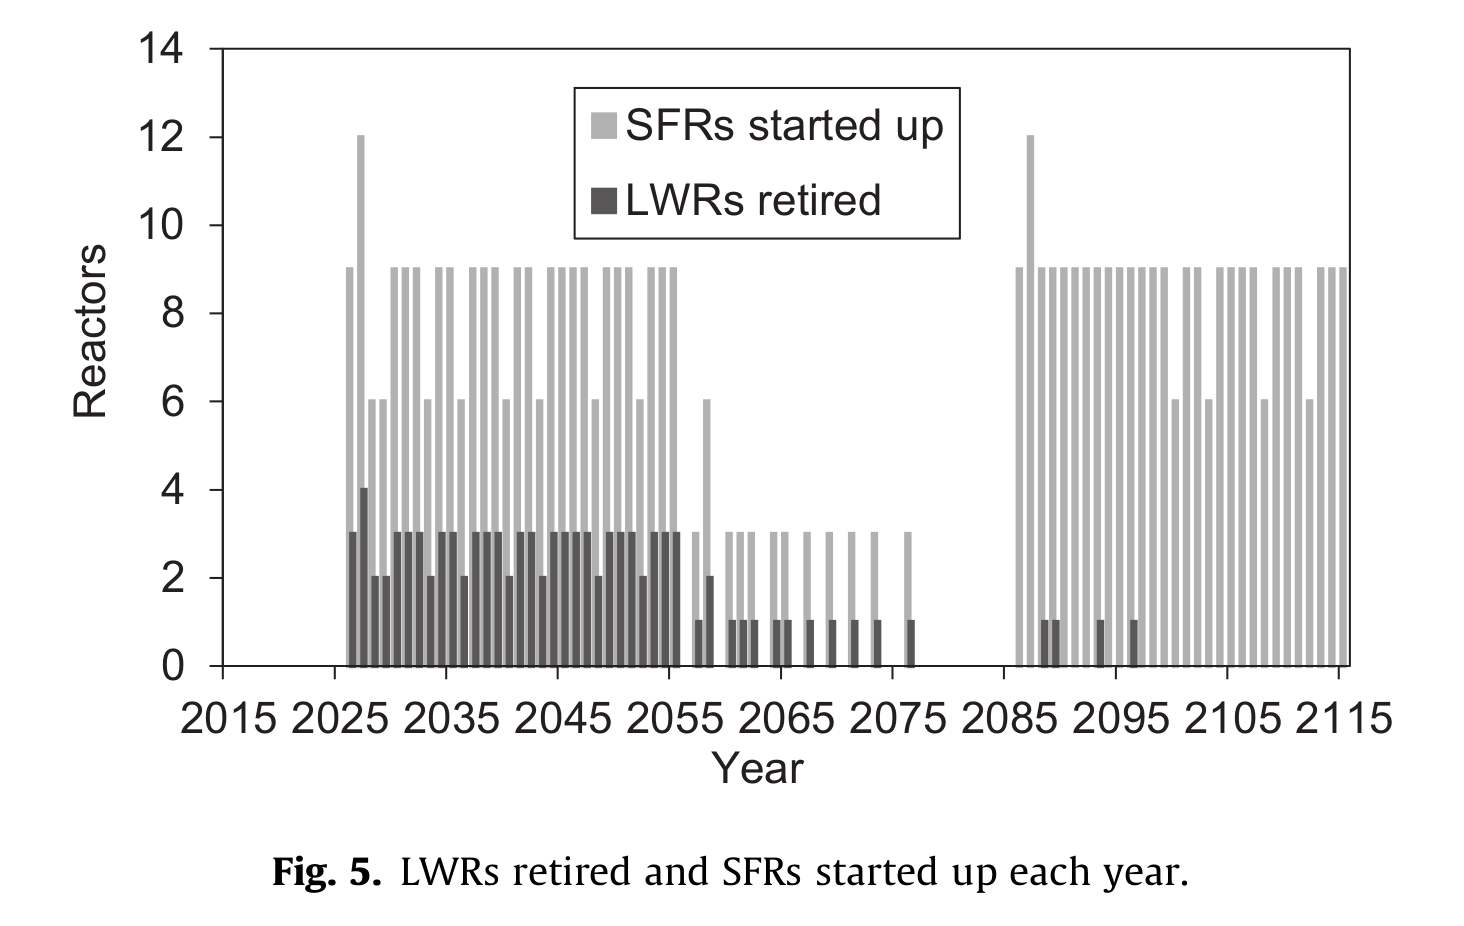

In [190]:
Image("./literature/dep.png")

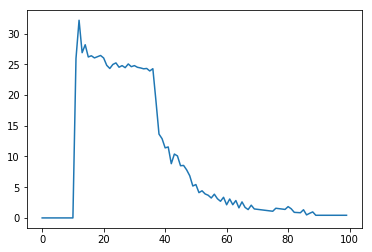

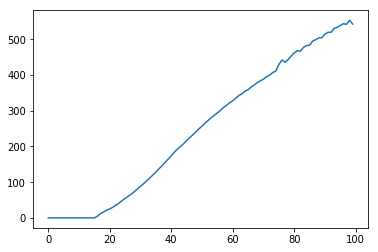

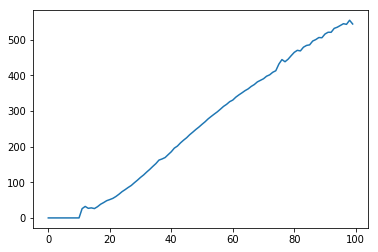

In [205]:
# unsed TRU recovered from UNF

# Get separated Pu stockpile
uox_pu_inv = cur.execute('SELECT time, Value FROM separationevents '
                         'WHERE type = "uox_pu"').fetchall()
sfr_pu_inv = cur.execute('SELECT time, Value FROM separationevents '
                         'WHERE type = "sfr_pu"').fetchall()

uox_pu_inv_timeseries = an.get_timeseries_cum(uox_pu_inv, duration, True)
sfr_pu_inv_timeseries = an.get_timeseries_cum(sfr_pu_inv, duration, True)


# Get Pu that's been used
sfr_load = an.facility_commodity_flux(cur, sfr_agentid,
                                      ['sfr_fuel_from_uox', 'sfr_fuel_from_sfr'],
                                      False, True)

uox_pu_used = [x * 0.1387 for x in sfr_load['sfr_fuel_from_uox']]
sfr_pu_used = [x * 0.1387 for x in sfr_load['sfr_fuel_from_sfr']]

plt.close()
uox_pu = [x - y for x, y in zip(uox_pu_inv_timeseries, uox_pu_used)]
sfr_pu = [x - y for x, y in zip(sfr_pu_inv_timeseries, sfr_pu_used)]

plt.plot(timestep, uox_pu)
plt.show()
plt.close()

plt.plot(timestep, sfr_pu)
plt.show()
plt.close()

total_pu = [x + y for x, y in zip(uox_pu, sfr_pu)]
plt.plot(timestep, total_pu)
plt.show()
plt.close()

In [191]:
# Annual Fresh Fuel Loading Rates

# lwr fuel loading 
lwr_agentid = an.get_prototype_id(cur, 'lwr')
lwr_load = an.facility_commodity_flux(cur, lwr_agentid,
                                      ['uox'], False, False)
## have to make the first datapoint equal to the second datapoint (BC)
## the first datapoint lwr_load['uox'][1] 
## is the initial loading of all lwrs
lwr_load['uox'][1] = lwr_load['uox'][2]
lwr_load['uox'][0] = lwr_load['uox'][1]


# sfr fuel loading
sfr_agentid = an.get_prototype_id(cur, 'sfr')
sfr_load = an.facility_commodity_flux(cur, sfr_agentid,
                                      ['sfr_fuel_from_uox', 'sfr_fuel_from_sfr'],
                                      False, False)
sfr_load_total = [x + y for x, y in zip(sfr_load['sfr_fuel_from_uox'],
                                        sfr_load['sfr_fuel_from_sfr'])]

plt.plot(timestep + init_year , lwr_load['uox'],
         label='LWR Fresh Fuel')
plt.plot(timestep + init_year, sfr_load_total,
         label='SFR Fresh Fuel')
plt.xlabel('Year')
plt.ylabel('Fresh Fuel Loading [MTHM]')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/fuel_load.png', format='png',
            bbox_inches='tight')
plt.close()

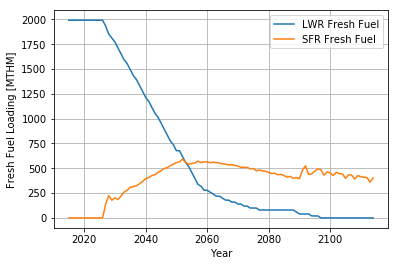

In [192]:
Image("./results/fuel_load.png")

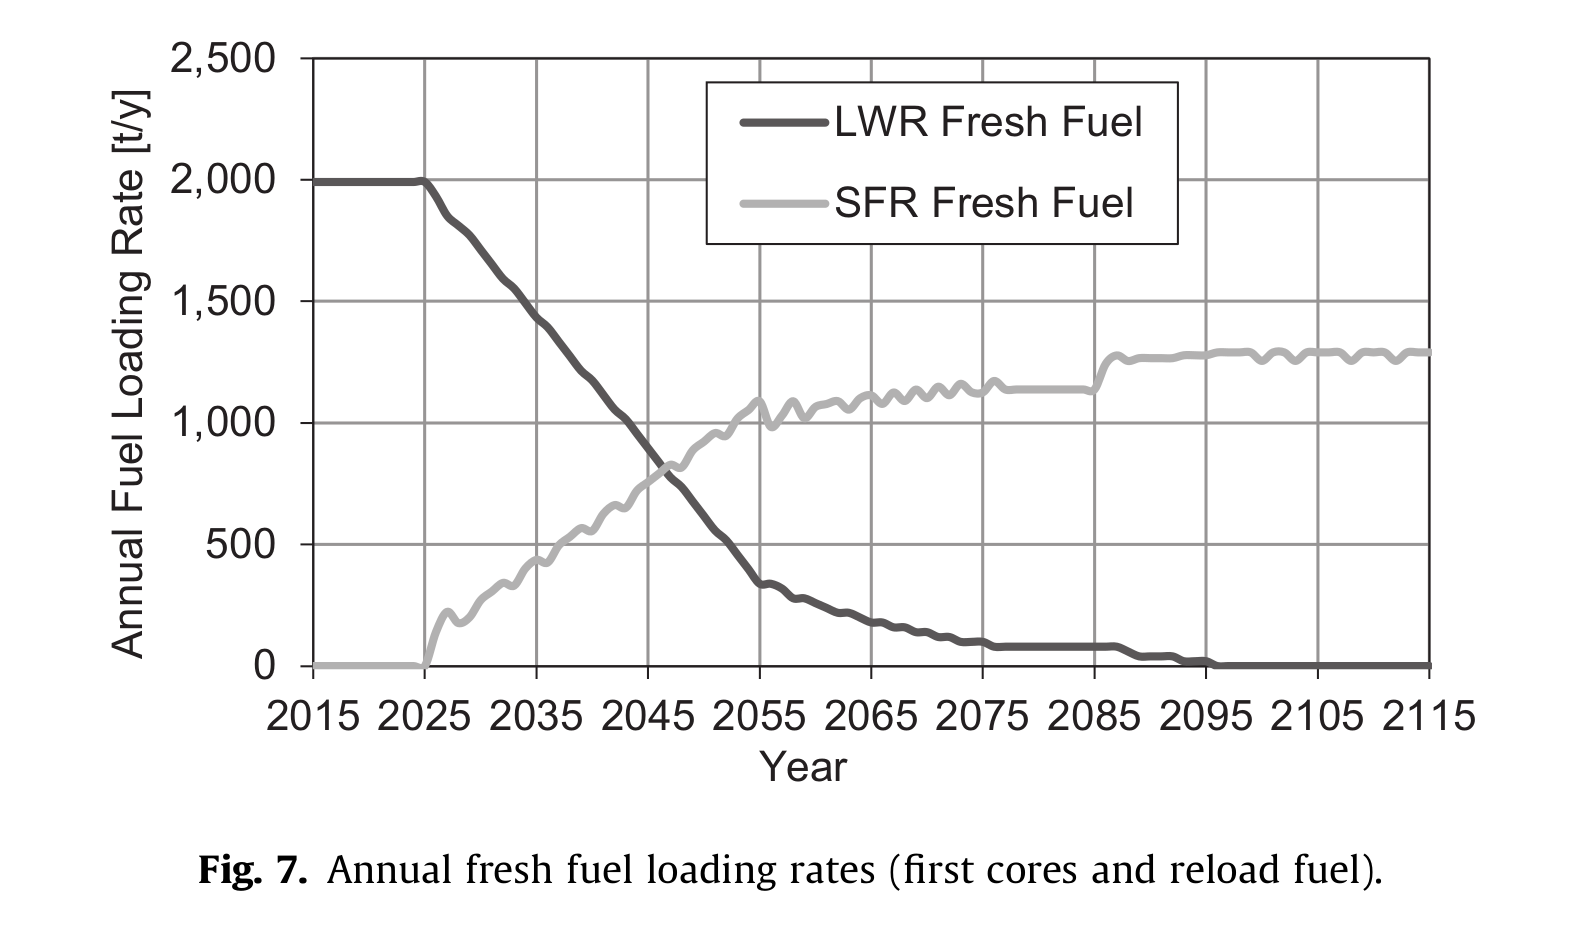

In [166]:
Image('./literature/fuel_load.png')

In [167]:
# Inventory of discharged and cooled UNF waiting for reprocessing

query_result = cur.execute('SELECT quantity FROM storageinventory '
                           'WHERE prototype = "uox_unf_storage" '
                           'AND status = "Cooling"').fetchall()
uox_storage_timeseries = [0]
for row in query_result:
    uox_storage_timeseries.append(row[0] / 1000.0)


sfr_query = cur.execute('SELECT quantity FROM storageinventory '
                        'WHERE prototype = "sfr_unf_storage" '
                        'AND status = "Cooling"').fetchall()
sfr_storage_timeseries = [0]
for row in sfr_query:
    sfr_storage_timeseries.append(row[0] / 1000.0)
    

plt.plot(timestep + init_year , uox_storage_timeseries,
             label='LWR UNF')
plt.plot(timestep + init_year, sfr_storage_timeseries,
         label='SFR UNF')
plt.xlabel('Year')
plt.ylabel('Used Fuel in Cooling Storage [t]')
plt.title('Inventory of discharged UNF in mandatory cooling storage')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/fuel_discharge.png', format='png',
            bbox_inches='tight')
plt.close()

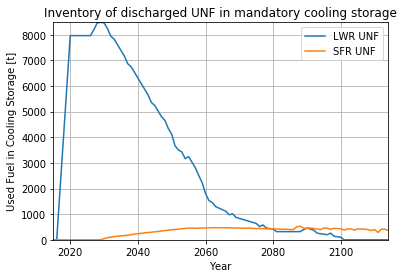

In [168]:
Image('./results/fuel_discharge.png')

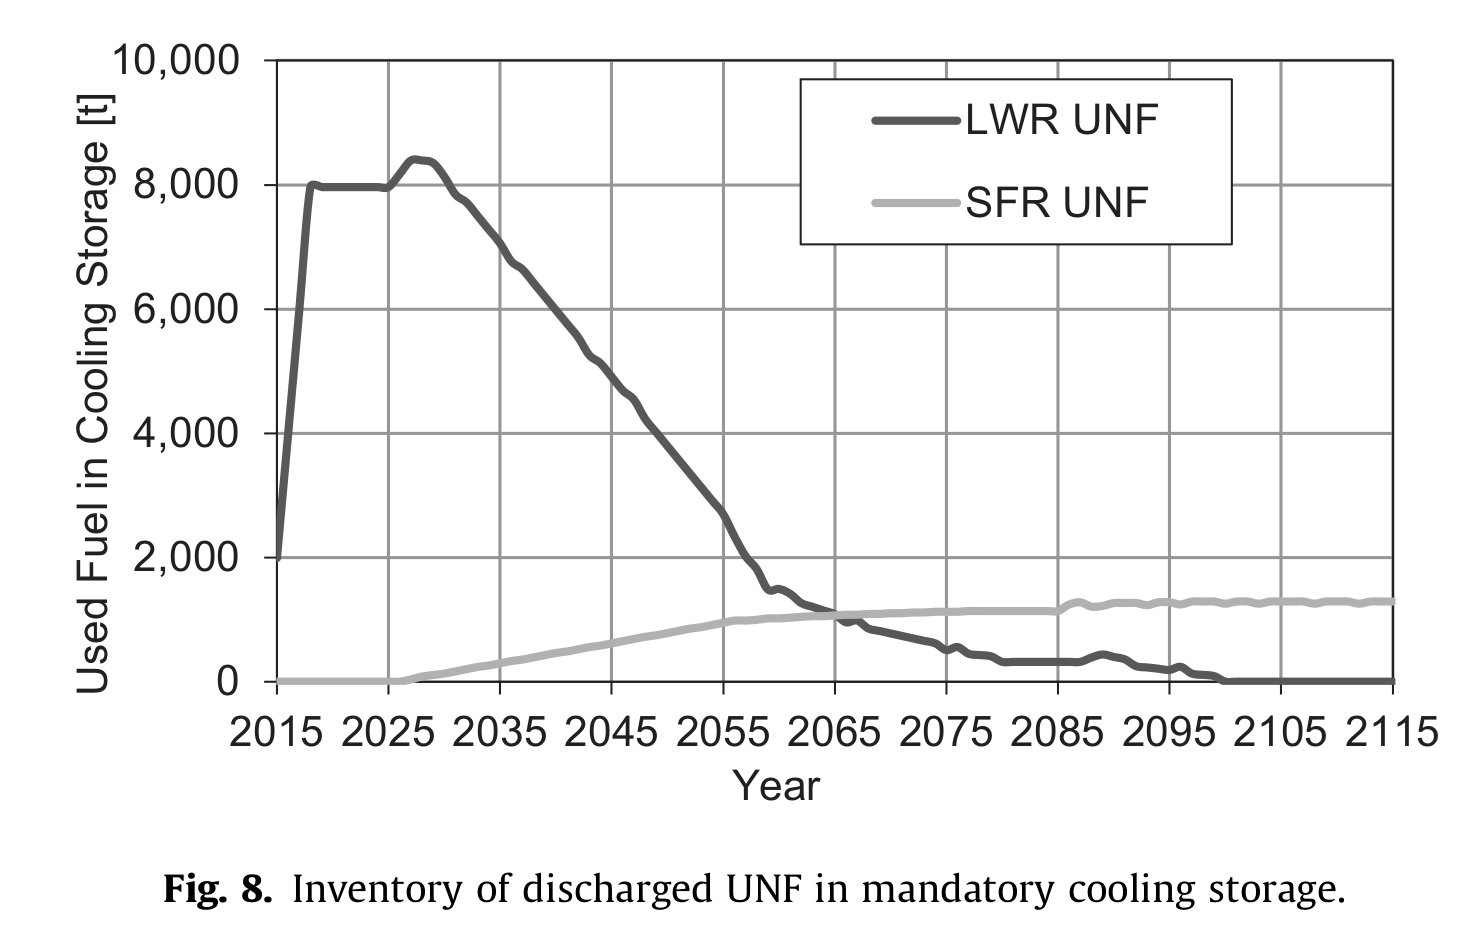

In [169]:
Image('./literature/fuel_discharge.png')

In [170]:
# Inventory of discharged and cooled UNF waiting for reprocessing
# Inventory of discharged and cooled UNF waiting for reprocessing

query_result = cur.execute('SELECT quantity FROM storageinventory '
                           'WHERE prototype = "uox_unf_storage" '
                           'AND status = "Cooled"').fetchall()
uox_storage_timeseries = [0]
for row in query_result:
    uox_storage_timeseries.append(row[0] / 1000.0)


sfr_query = cur.execute('SELECT quantity FROM storageinventory '
                        'WHERE prototype = "sfr_unf_storage" '
                        'AND status = "Cooled"').fetchall()
sfr_storage_timeseries = [0]
for row in sfr_query:
    sfr_storage_timeseries.append(row[0] / 1000.0)
    

plt.plot(timestep + init_year , uox_storage_timeseries,
             label='LWR UNF')
plt.plot(timestep + init_year, sfr_storage_timeseries,
         label='SFR UNF')
plt.xlabel('Year')
plt.ylabel('UNF waiting for Reprocessing [MTHM]')
plt.title('Inventory of discharge and cooled UNF waiting for reprocessing')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/waiting.png', format='png',
            bbox_inches='tight')
plt.close()

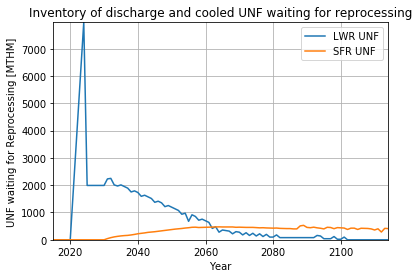

In [171]:
Image('./results/waiting.png')

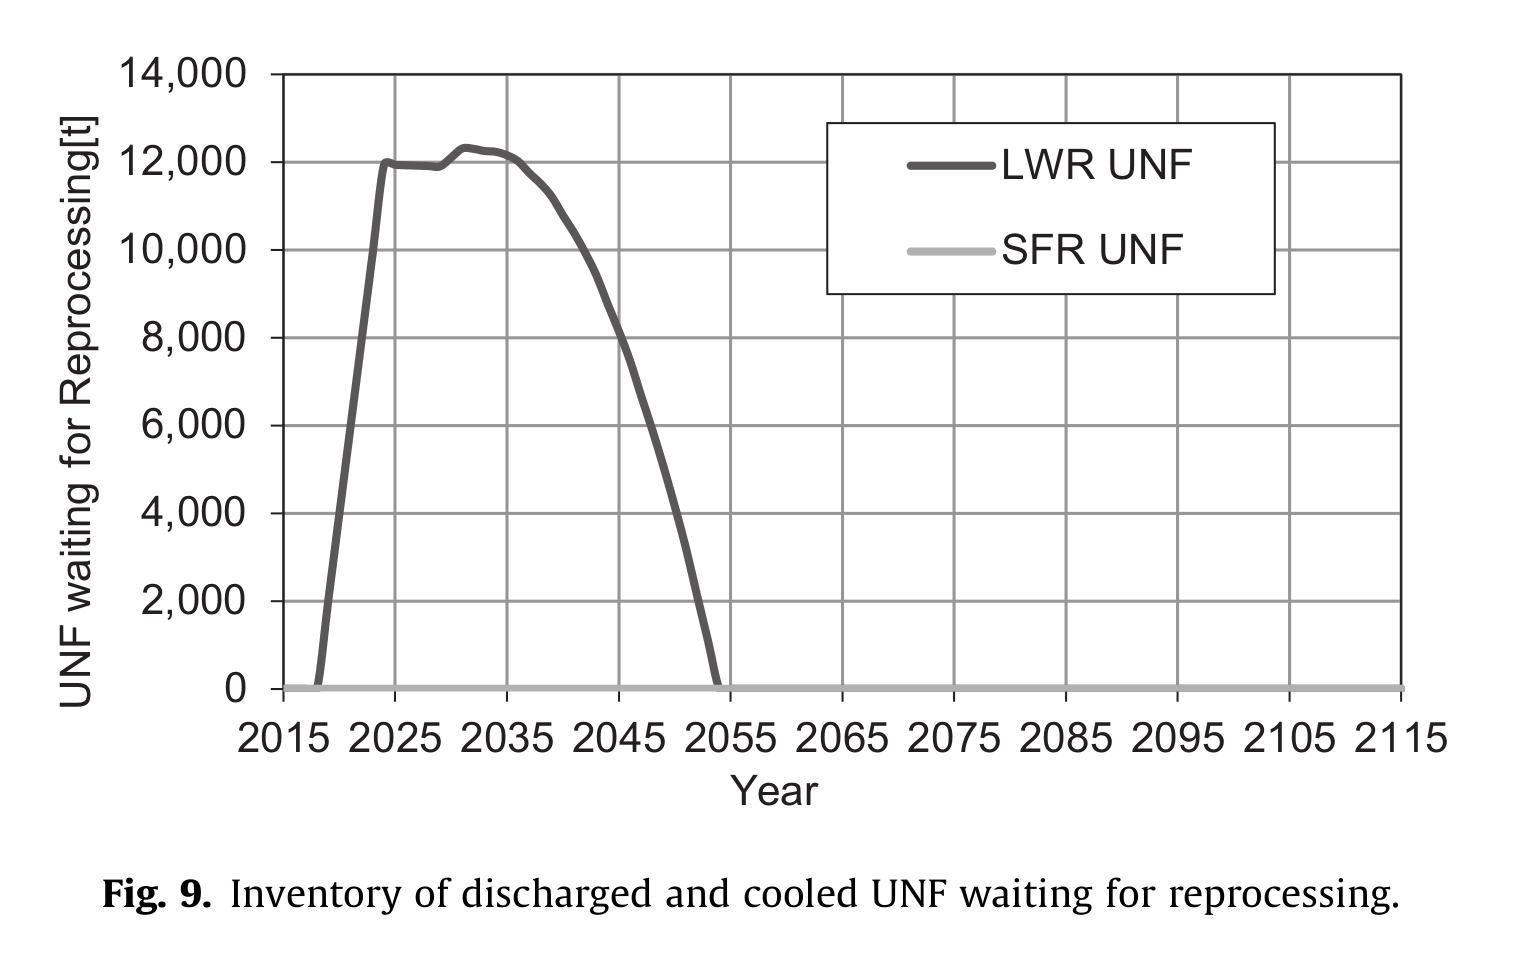

In [172]:
Image('./literature/waiting.png')

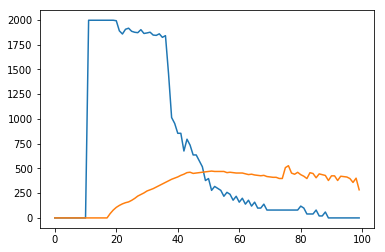

In [173]:
# annual Reprocessing throughputs
# is going to be TRU (pu) output divided by the composition of plutonium


# for uox reprocessing (0.013 pu in used uox fuel)
uox_rep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
# get outflux
uox_pu_out = an.facility_commodity_flux(cur, uox_rep_agentid,
                                        ['uox_pu'], True, False)
uox_rep_throughput = np.array(uox_pu_out['uox_pu']) / 0.013


# for sfr reprocessing (0.1404 pu in used sfr fuel)
sfr_rep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
# get outflux
sfr_pu_out = an.facility_commodity_flux(cur, sfr_rep_agentid,
                                        ['sfr_pu'], True, False)
sfr_rep_throughput = np.array(sfr_pu_out['sfr_pu']) / 0.1404

plt.plot(timestep, uox_rep_throughput)
plt.plot(timestep, sfr_rep_throughput)
plt.xlabel('Year')
plt.ylabel('Annual Reprocessing Rate [t/y]')
plt.title('Annual reprocessing throughputs')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/rep.png', format='png',
            bbox_inches='tight')
plt.close()

In [ ]:
Image('./results/rep.png')

In [ ]:
Image('./literature/rep.png')